# Analysis Pipeline for Video Audio Video Comprehension

## Previous work 
<img src="ScriptDescriptions.png" width = 1000>

```
script_path = '/Volumes/GoogleDrive/My Drive/EEG_DATA_PIERRE/Scripts'
```

### MNE python
Working on the MNE library to recreate the same matlab funcitons: 
Location:
https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

## Matlab code

``` 
load('Params');
```

#### PREPROCESSING OF DATA
Additional options are 'task' for timeline figure or 'behavior' for histogram with behavioral data
```
[EventData, BEEPdata] = PreProcessPop(Params, 'padding', 2);                
```
    
#### AUTOMATIC ARTEFACT REJECTION - INTERPOLATION - INDEPENDANT COMPONENT ANALYSIS
```
[CleanData, trials, BadIdx] = reject_artefact(EventData);
save TrialIndex trials
save BadChannelIndex BadIdx

popout_ica(CleanData);

[cleanBEEPData, ~ , ~] = reject_artefact(BEEPdata);

popout_ica(cleanBEEPData);
```


#### PREPROCESSING OF SOUND ENVELOPPE 
```
cfgSound = [];
cfgSound.trials     = 'all';%trialIdx;
cfgSound.channel    = 'audio';
cfgSound.dftfilter  = 'yes';
cfgSound.dftfreq    = [50 100 150];
cfgSound.hpfilter   = 'yes';
cfgSound.hpfilttype = 'but';
cfgSound.hpfiltord  = 8;
cfgSound.hpfreq     = 100;

sound               = ft_preprocessing(cfgSound,EventData(2,1));

save('data_sound', 'sound')
% save('BEEP_sound', 'sound')
```

In [1]:
data_path = '/Volumes/GoogleDrive/My Drive/EEG_DATA_PIERRE/S20'
script_path = '/Volumes/GoogleDrive/My Drive/EEG_DATA_PIERRE/Scripts'


In [2]:
# IMPORTS: 
import os
import numpy as np
import mne
import scipy

# sample_data_folder = mne.datasets.sample.data_path()
# sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
#                                     'sample_audvis_filt-0-40_raw.fif')
# raw = mne.io.read_raw_fif(sample_data_raw_file)


In [3]:
# LOAD DATA 
data_raw_file = os.path.join(data_path, 'S20_20181217_014956.mff')
raw = mne.io.read_raw_egi(data_raw_file)


Reading EGI MFF Header from /Volumes/GoogleDrive/My Drive/EEG_DATA_PIERRE/S20/S20_20181217_014956.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...


<Info | 7 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 257 EEG, 12 STIM, 1 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2018-12-17 12:49:55 UTC
 nchan: 270
 projs: []
 sfreq: 1000.0 Hz
>
[]
11


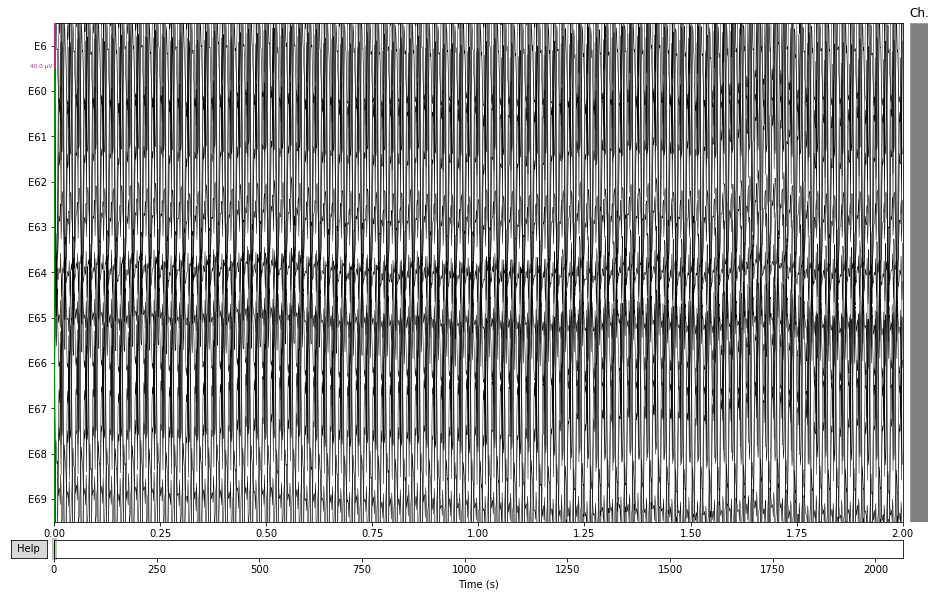

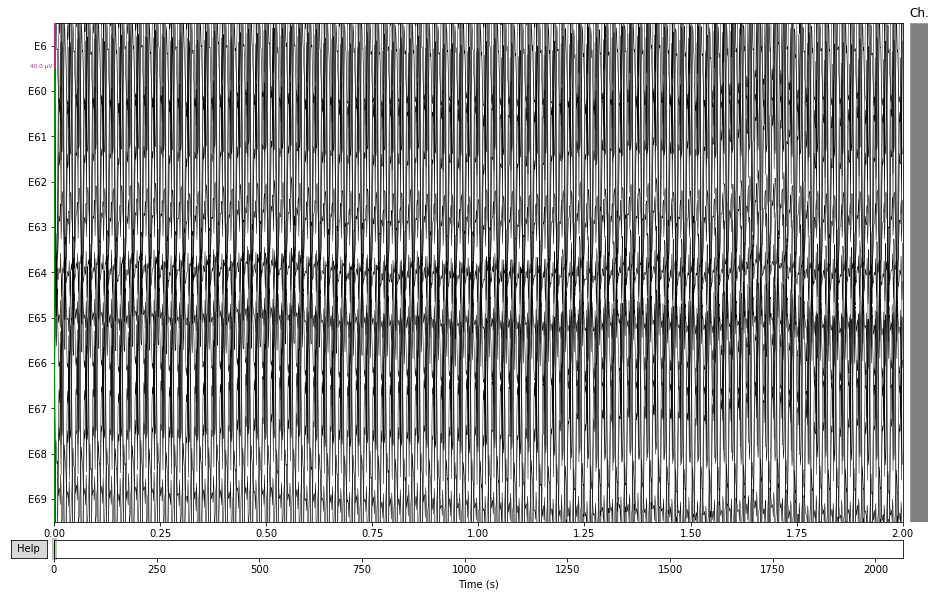

In [24]:
# print(raw)
print(raw.info)
infodata = raw.info
# raw.plot(duration=60)
print(raw.info['bads'])
picks = mne.pick_channels_regexp(raw.info.ch_names, regexp='E6')
print(len(picks))
raw.plot(order=picks, n_channels=len(picks), duration=2)

[268]


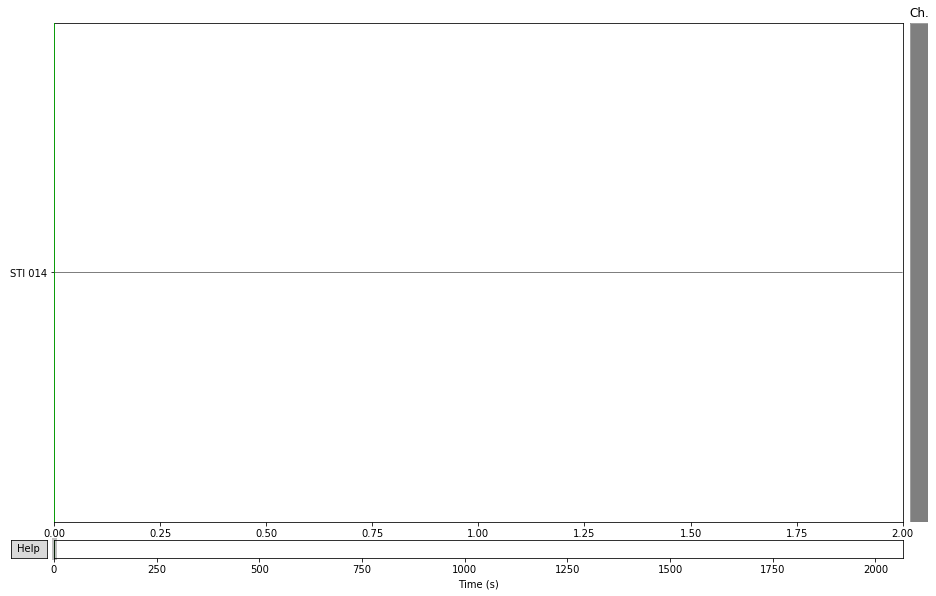

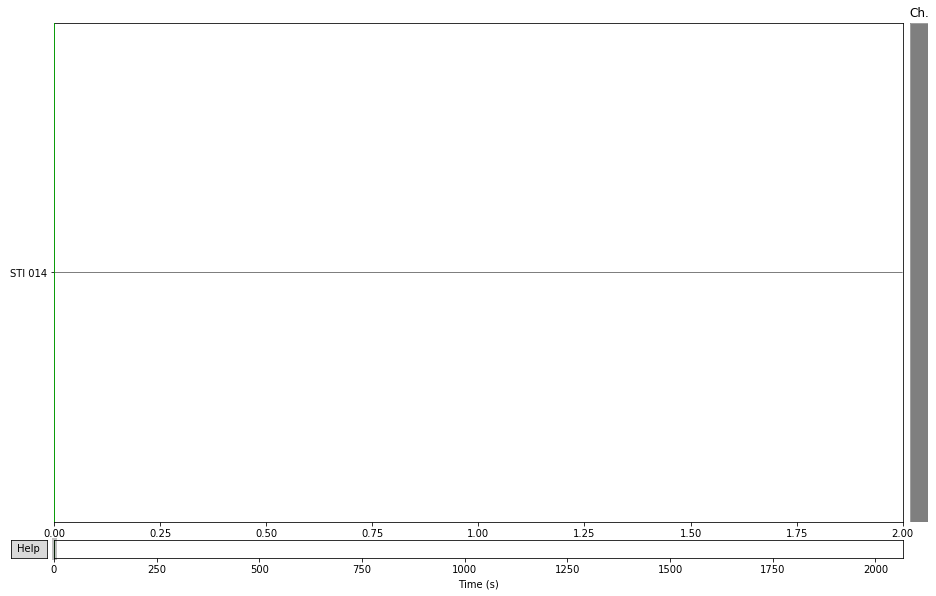

In [28]:
raw2 = raw.copy()
raw2.info['bads'] = []
picks = mne.pick_channels_regexp(raw2.info.ch_names, regexp='S')
print(picks)
raw2.plot(order=picks, n_channels=len(picks), duration=2)


[268]


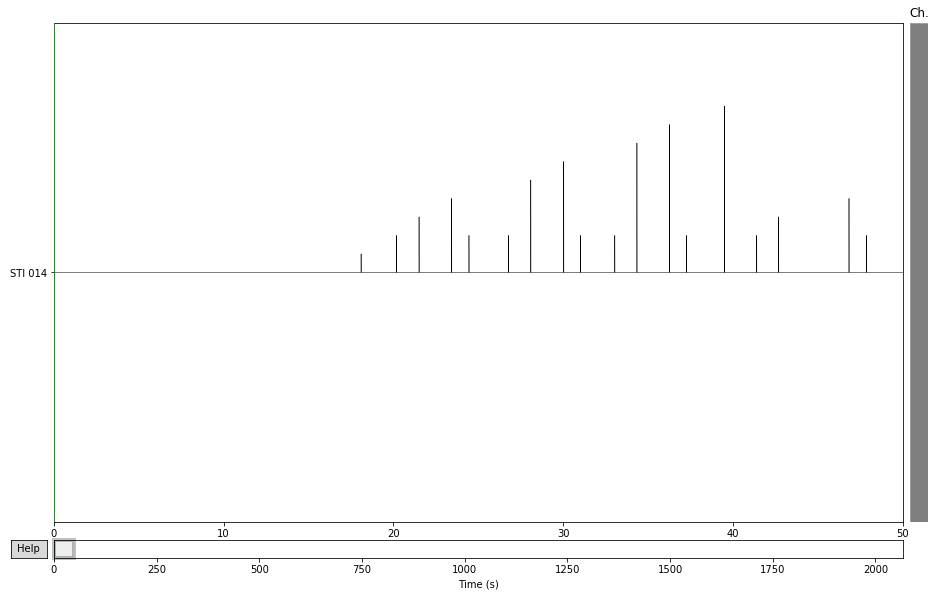

KeyboardInterrupt: 

In [35]:
raw2 = raw.copy()
raw2.info['bads'] = []
picks = mne.pick_channels_regexp(raw2.info.ch_names, regexp='S')
print(picks)
raw2.plot(order=picks, n_channels=len(picks), duration=50)
events = mne.find_events(raw2, stim_channel='STI 014')
print(events)
# epochs = mne.Epochs(raw2, events=events)['2'].average().plot()

### Independend Component Analysis: 
```
[CleanData, trials, BadIdx] = reject_artefact(EventData);
save TrialIndex trials
save BadChannelIndex BadIdx

popout_ica(CleanData);

[cleanBEEPData, ~ , ~] = reject_artefact(BEEPdata);

popout_ica(cleanBEEPData);
```



In [ ]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
temporary = os.path.join(data_path, 'BadChannelIndex.mat')
ica.exclude = scipy.io.loadmat(temporary)  # [1, 2]  # details on how we picked these are omitted here

ica.plot_properties(raw, picks=ica.exclude)

In [ ]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# identify channels
temporary = os.path.join(data_path, 'Params.mat')
params = scipy.io.loadmat(temporary)  # 



# show some frontal channels to clearly illustrate the artifact removal
chs =  params.channels # ['e1','e2']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

### Triggers: 
```
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5
```

In [ ]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

# event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
#               'visual/right': 4, 'smiley': 5, 'buttonpress': 32} 
event_dict = params.triggers

fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)